In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plot
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import odeint
import matplotlib.dates as mdate
import pandas as pd

In [4]:
GC,GR = modular_network(2000,0.05)

In [5]:
AC = nx.to_numpy_array(GC)
AR = nx.to_numpy_array(GR)

In [6]:
#平均度
np.mean(np.sum(A,axis=0))

NameError: name 'A' is not defined

In [7]:
#平均聚集系数
np.array(list(nx.clustering(GC).values())).mean()

0.10349639892992384

In [8]:
np.array(list(nx.clustering(GR).values())).mean()

0.05568978353322769

In [9]:
nx.average_shortest_path_length(GC)

2.5387286661665813

In [10]:
nx.average_shortest_path_length(GR)

2.4706006332937247

In [53]:
def call(A):    
    r0 = 12
    gamma = 1/14
    betae = r0*gamma
    betai = r0*gamma*6/4
    incubation = 9.5
    alpha = 0.13

    #核酸检测窗口
    w = 1/7

    #检测力度
    p = 1

    #接触能力
    c = 0.02

    #静态管控时长
    control_time = 300

    X0 = np.zeros(len(A))
    #seed spreader
    X0[60] = 2

    interval = []
    fig = plt.figure(figsize=(12,8))
    plt.tick_params(labelsize = 25)
    #************多次模拟**************#
    for ii in range(30):
        S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
        plt.plot(Te)
        time = 0
        for jj in range(len(Te)):
                if Te[jj]>50:
                    time = jj-1
                if time != 0:
                    break
        if time != 0:
            interval.append(time)
    # data.reset_index(drop=True, inplace=True)
    # plt.plot(aug_data['累计新增'][:len(Te)],marker='o',lw=1,c='b',label = 'Real Data')
    # plt.legend(fontsize = 18)
    return interval

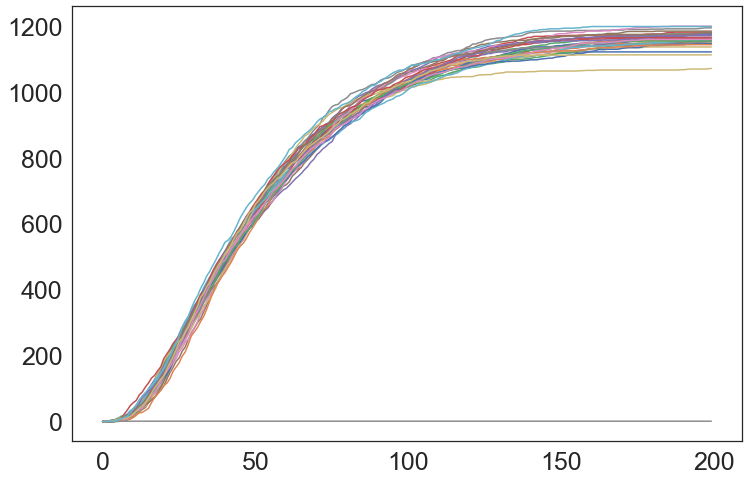

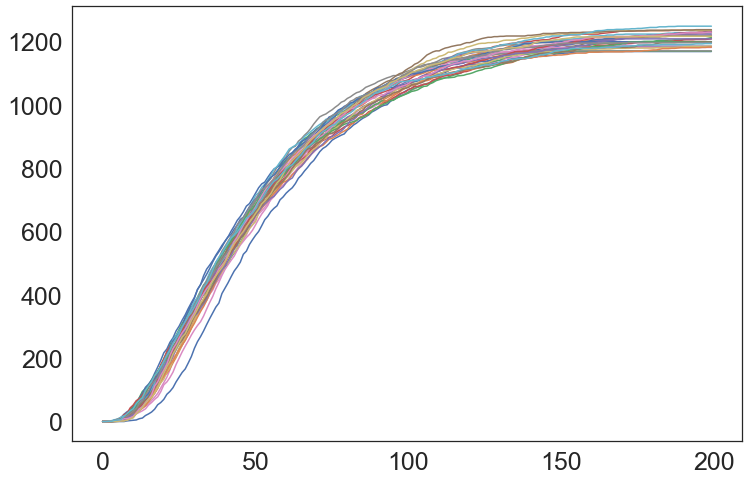

In [62]:
interC = call(AC)
interR = call(AR)

In [63]:
xc = pd.Series(interC)  

In [64]:
xr = pd.Series(interR)  

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


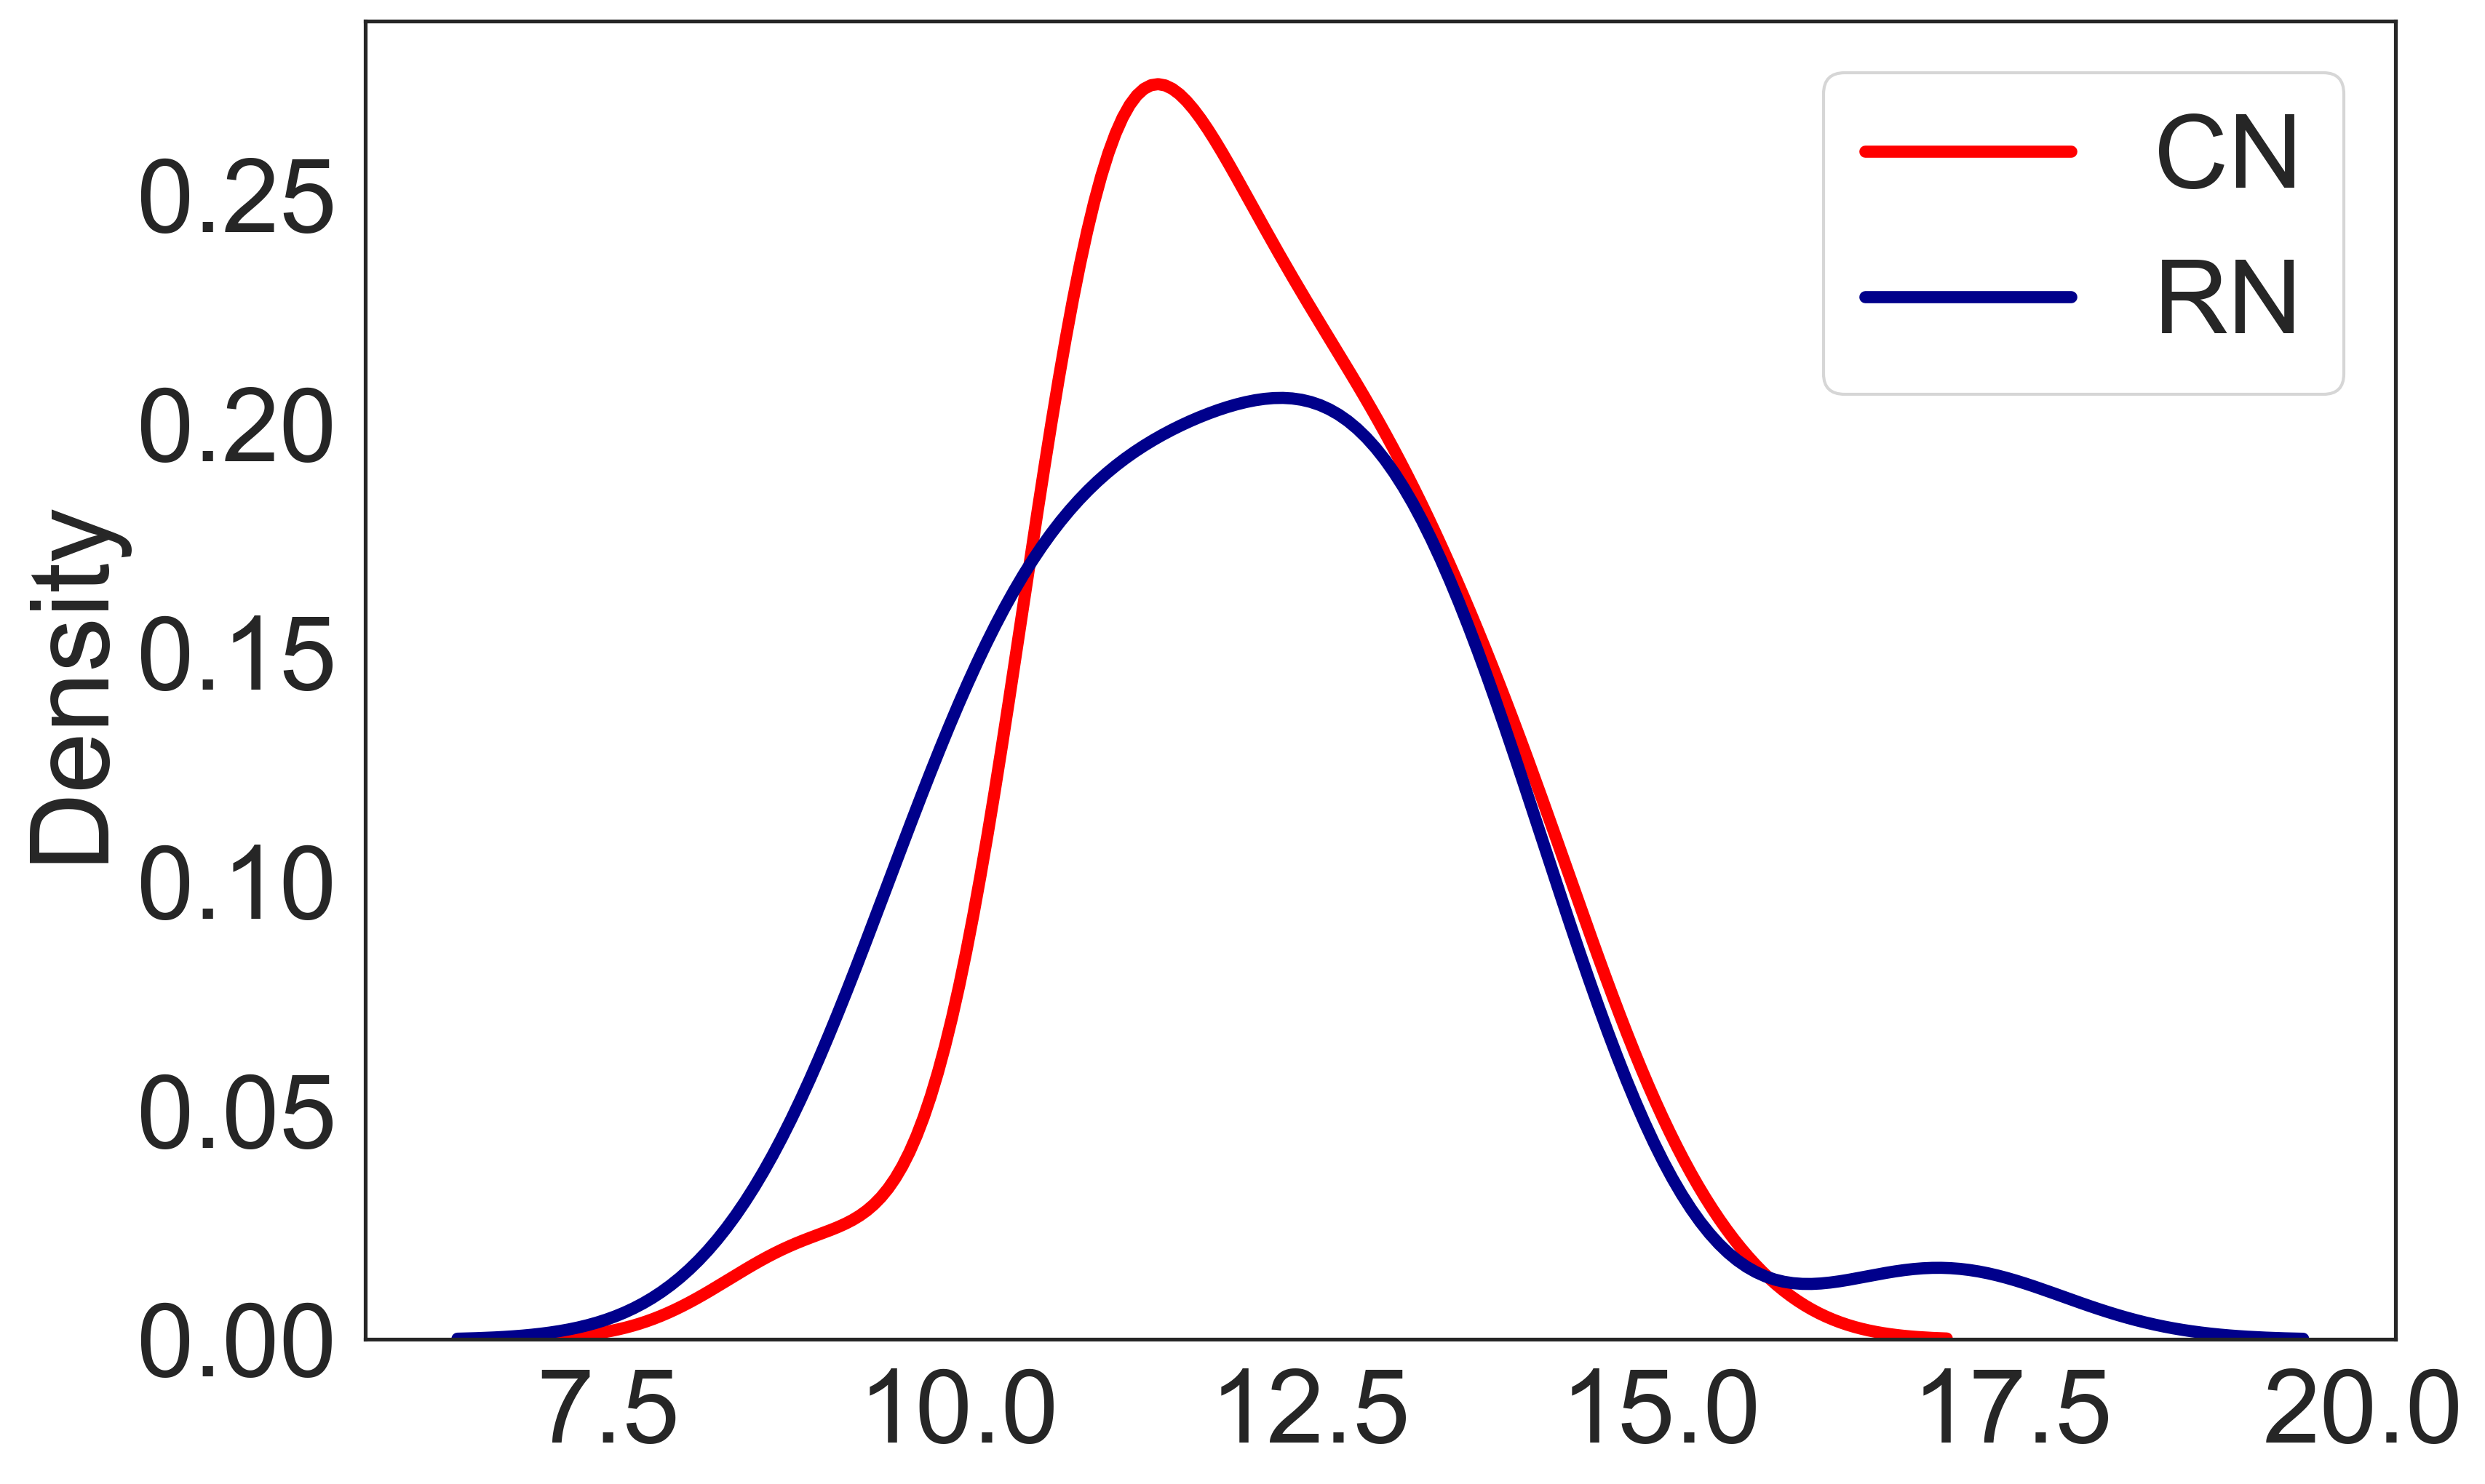

In [65]:
import seaborn as sns
sns.set(font_scale=3)
sns.set_style(style='white') 
fig = plt.figure(figsize=(12,8),dpi=300)
sns.distplot(xc, hist=False, kde=True, 
             bins=10, color = 'red', 
             kde_kws={'linewidth': 4}, label = 'CN')
sns.distplot(xr, hist=False, kde=True, 
             bins=10, color = 'darkblue', 
             kde_kws={'linewidth': 4}, label = 'RN')
plt.legend(fontsize = 34)
# plt.xlim([0,27])
plt.tick_params(labelsize = 34)

In [2]:
def modular_network(N,p):
#     gm = nx.utils.powerlaw_sequence(N,3)
    gm = np.random.exponential(4,N)
    m = np.array([int(x) for x in gm])
    s = 0
    pn = []
    while s<np.sum(m):
#         num = int(nx.utils.powerlaw_sequence(1,2)[0])
        num = int(np.random.exponential(40,1)[0])
        s = s+num
        pn.append(num)
    pn = np.array(pn)
    if np.sum(pn)>np.sum(m):
        pn[-1] = np.sum(m) - np.sum(pn[:-1])
    ####
    
    M = []
    for i in range(len(m)):
        M = M+[i]*m[i]
    P = []
    for i in range(len(pn)):
        P = P+[i]*pn[i]
    
    Pr = np.array(P.copy())
    Mr = np.array(M.copy())
    
    random.shuffle(Pr)
    random.shuffle(Mr)
    
    Dic = {}
    for i in np.arange(0,max(Pr)+1):
        Dic[i] = Mr[Pr==i]
        
        
        
    B = np.zeros((N,N))

    for key in Dic:
        value = Dic[key]
        if len(value)>1:
            for i in value:
                for j in value:
                    if np.random.random()<=p:
                        B[i,j] = 1
                    
    B = B - np.eye(N)
    GG = nx.Graph(B)
    C = sorted(nx.connected_components(GG),key = len,reverse = True)
    GG1 = GG.subgraph(C[0])
    ####
    A1 = nx.to_numpy_array(GG1)
    GG1 = nx.Graph(A1)
    
    
    K = np.array([v for u,v in GG1.degree()])
    GX = nx.configuration_model(K)
    GX = nx.Graph(GX)
    
    return GG1,GX

In [3]:
def update_model(X,A,incubation,betae,betai,alpha,gamma,p,w,c):
    ID = np.arange(len(A))
    nX = X.copy()
    for i in range(len(X)):
        neighbor_ID = ID[A[i]>0]#寻找邻居
        if X[i] == 0:#suspectible 
            #统计邻居节点状态进行感染
            #计算有多少
            nume=0
            numi=0
            for ni in neighbor_ID:
                if X[ni] == 1:
                    #S碰到E，统计人数
                    nume+=1
                elif X[ni] == 2:
                    #S碰到I
                    numi+=1
            #根据现有多少个A和I来计算传播概率*管控力度
            if np.random.random()< c*(1-(1-betai)**numi*(1-betae)**nume):
                nX[i] = 1
        if X[i] == 1:#ecubate
            #以潜伏天数的倒数*一定感染概率alpha转为确诊，或被移除
            if np.random.random()< 1/incubation:
                if np.random.random()< alpha:
                    nX[i] = 2#i
                else:
                    nX[i] = 4#r
                #检测力度被检测出来
                if np.random.random()< p:
                    nX[i] = 3#t
        if X[i] == 2:#infected to tested or recover 
            if np.random.random()< w * p:
                nX[i] = 3#t
            if np.random.random() < gamma:
                nX[i] = 4      
    return nX
                    
    
def loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time):
    T = 200
    Xp = X0.copy()
    S = np.zeros(T)
    E = np.zeros(T)
    I = np.zeros(T)
    Te = np.zeros(T)
    R = np.zeros(T)
    
    S[0] = np.sum(X0==0)
    E[0] = np.sum(X0==1)
    I[0] = np.sum(X0==2)
    Te[0] = np.sum(X0==3)
    R[0] = np.sum(X0==4)
    
    for t in range(T-1):  
        nX = update_model(Xp,A,incubation,betae,betai,alpha,gamma,p,w,c)
        Xp = nX.copy()
        S[t+1] = np.sum(nX==0)
        E[t+1] = np.sum(nX==1)
        I[t+1] = np.sum(nX==2)
        Te[t+1] = np.sum(nX==3)
        R[t+1] = np.sum(nX==4)
    return S,E,I,Te,R,nX 